In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
import os
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from sktime.clustering.k_means import TimeSeriesKMeans
from sklearn.model_selection import train_test_split

In [22]:
# Load data
time_series = pd.read_csv('dataset/tabular/time_series.csv')

In [25]:
# normalize data with MinMaxScaler without the last two columns
scaler = MinMaxScaler()
time_series.iloc[:, :-2] = scaler.fit_transform(time_series.iloc[:, :-2])
time_series = time_series.drop(columns=['genre', 'track_id'])

## Distance-based Clustering


In [37]:
def load_npy(filename):
    return np.load(filename)


dir_path = 'dataset/time_series/'
len_threshold = 1280
X, y, ids = [], [], []

for file in os.listdir(dir_path):
    if os.path.splitext(file)[1] != '.npy':
        continue

    split = file.split("_")
    ids.append(split[0])  # track_id
    y.append(split[1][:-4])  # genre
    ts = load_npy(dir_path + file)

    if len(ts) > len_threshold:
        ts = ts[0:len_threshold]
    else:
        # pad = [np.mean(ts[:-5])] * (len_threshold-len(ts)) # fill by mean value of last n observations
        pad = [ts[-1]] * (len_threshold - len(ts))  # fill with last observation
        ts = np.append(ts, pad)

    X.append([ts])

X, y, ids = np.array(X), np.array(y), np.array(ids) # y is the genre, X is the time series, ids is the track_id

### Euclidean

In [59]:
# Normalize the data in sktime format with minmax scaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

In [45]:
clusterer = TimeSeriesKMeans(n_clusters=2, metric="euclidean")

In [46]:
%%time
clusterer.fit(X)

CPU times: user 3.97 s, sys: 637 ms, total: 4.61 s
Wall time: 4.9 s


TimeSeriesKMeans(metric='euclidean', n_clusters=2)

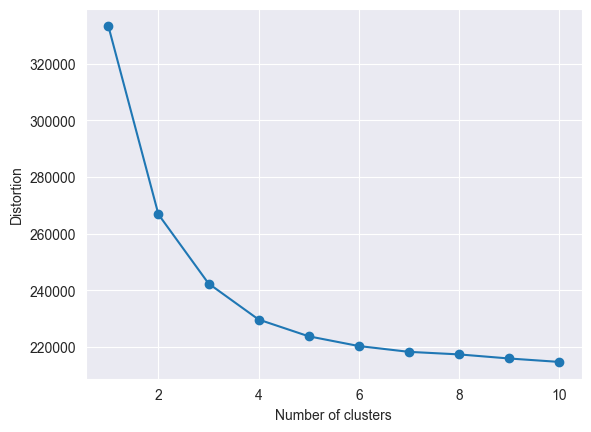

CPU times: user 3min 51s, sys: 15.4 s, total: 4min 6s
Wall time: 4min 17s


In [47]:
%%time
# Run elbow method to find the optimal number of clusters
distortions = []
for i in range(1, 11):
    km = TimeSeriesKMeans(n_clusters=i, metric="euclidean")
    km.fit(X)
    distortions.append(km.inertia_)
    
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [62]:
%%time
# Run elbow method to find the optimal number of clusters
distortions = []
for i in range(1, 11):
    km = TimeSeriesKMeans(n_clusters=i, metric="dtw")
    km.fit(X)
    distortions.append(km.inertia_)

plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

KeyboardInterrupt: 

In [52]:
X.shape

(10000, 1, 1280)

In [53]:
clusterer = TimeSeriesKMeans(n_clusters=4, metric="euclidean")
clusterer.fit(X)

TimeSeriesKMeans(metric='euclidean', n_clusters=4)

In [55]:
df = pd.DataFrame(np.squeeze(X))
df['cluster'] = clusterer.labels_

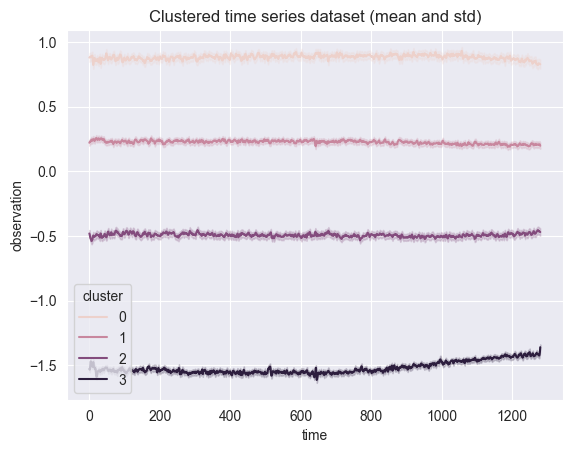

In [56]:
df_melt = df.melt(value_name="observation", var_name="time", id_vars="cluster")
sns.lineplot(df_melt, x="time", y="observation", hue="cluster")
plt.title("Clustered time series dataset (mean and std)")
plt.show()

In [20]:
time_series.iloc[359]

ts_0                      0.591179
ts_1                      0.560187
ts_2                      0.504148
ts_3                      0.341536
ts_4                      0.329405
                     ...          
ts_1277                    0.35244
ts_1278                   0.414929
ts_1279                   0.328572
genre               minimal-techno
track_id    3mY2rlrOlyG9VTJvlhFFId
Name: 359, Length: 1282, dtype: object

In [4]:
# remove from the dataset the columns genre and track_id
time_series = time_series.drop(columns=['genre', 'track_id'])

In [8]:
# Run Isolation Forest to detect anomalies
from sklearn.ensemble import IsolationForest
# fit the model
clf = IsolationForest(random_state=42, max_samples=10000)
clf.fit(time_series)

IsolationForest(max_samples=10000, random_state=42)

In [9]:
# predict the anomaly
time_series['anomaly'] = clf.predict(time_series)

In [10]:
# plot the anomaly
time_series['anomaly'].value_counts()

anomaly
 1    9905
-1      95
Name: count, dtype: int64

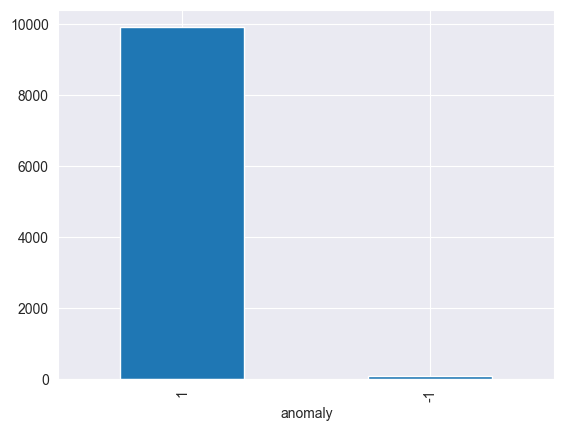

In [11]:
# plot the anomaly
time_series['anomaly'].value_counts().plot(kind='bar')
plt.show()

In [12]:
# Show the anomalies in the dataset
time_series[time_series['anomaly'] == -1]

,ts_0,ts_1,ts_2,ts_3,ts_4,ts_5,ts_6,ts_7,ts_8,ts_9,...,ts_1271,ts_1272,ts_1273,ts_1274,ts_1275,ts_1276,ts_1277,ts_1278,ts_1279,anomaly
95,0.515996,0.513484,0.543417,0.564314,0.572260,0.592499,0.612087,0.626174,0.620279,0.620402,...,0.528360,0.502563,0.500431,0.571845,0.575393,0.581596,0.560725,0.566410,0.591777,-1
225,0.577977,0.552613,0.472365,0.376635,0.331942,0.368309,0.336055,0.333512,0.339684,0.368166,...,0.514345,0.502863,0.447766,0.524695,0.547965,0.531701,0.444757,0.450998,0.505721,-1
359,0.591179,0.560187,0.504148,0.341536,0.329405,0.299825,0.134157,0.063606,0.091587,0.247277,...,0.096896,0.504412,0.680720,0.768873,0.595555,0.386268,0.352440,0.414929,0.328572,-1
390,0.393497,0.388599,0.376907,0.384367,0.373978,0.373377,0.393343,0.377442,0.349795,0.342060,...,0.699139,0.492554,0.355257,0.342227,0.306894,0.288948,0.236725,0.222567,0.235884,-1
441,0.187259,0.097730,0.026212,0.014299,0.012854,0.012241,0.011405,0.014394,0.021996,0.368721,...,0.245273,0.185558,0.086731,0.021135,0.012487,0.011473,0.010646,0.011518,0.013602,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9698,0.483242,0.521756,0.560927,0.594990,0.623667,0.627310,0.600049,0.574007,0.496015,0.335089,...,0.781878,0.769360,0.751614,0.582663,0.425601,0.435085,0.435673,0.441460,0.488373,-1
9796,0.265706,0.232924,0.220864,0.242453,0.231610,0.196861,0.217427,0.202293,0.131725,0.253283,...,0.455848,0.470291,0.372854,0.235101,0.114577,0.077728,0.056372,0.047919,0.046244,-1
9808,0.107017,0.099652,0.091024,0.090218,0.084634,0.082327,0.080341,0.078137,0.073595,0.068640,...,0.899038,0.829581,0.729165,0.449131,0.215348,0.264981,0.305355,0.333055,0.326696,-1
9864,0.226162,0.318889,0.480957,0.530532,0.469947,0.424630,0.389002,0.391312,0.436644,0.421938,...,0.407737,0.253845,0.120779,0.070261,0.058381,0.172088,0.310579,0.290670,0.204967,-1


<Axes: >

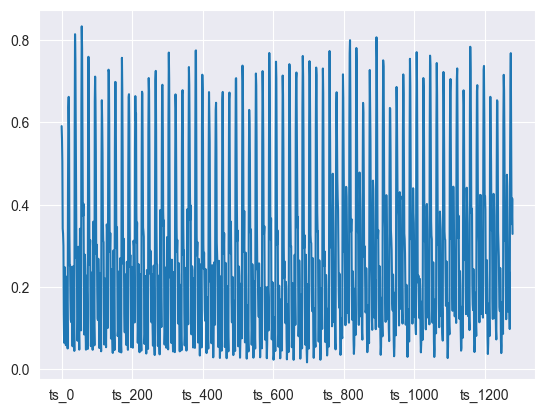

In [15]:
# plot the time series number 95
time_series.iloc[359, :-1].plot()